/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_38015/833285574.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance["region"] = insurance["region"].str.lower()


Linear Regression - Test MSE: 42255691.29, Test R2: 0.67
Decision Tree - Test MSE: 39298583.00, Test R2: 0.69
Random Forest - Test MSE: 26816551.59, Test R2: 0.79
Gradient Boosting - Test MSE: 23148769.72, Test R2: 0.82


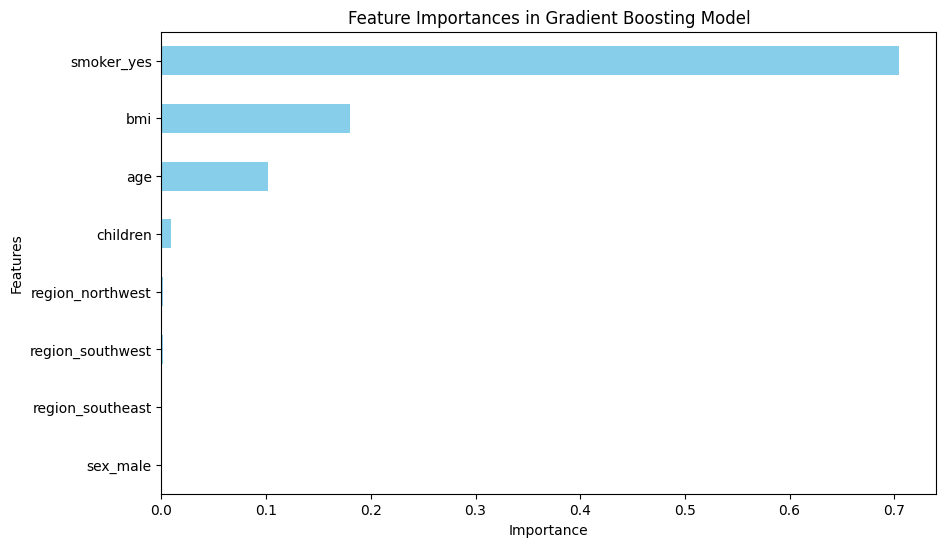

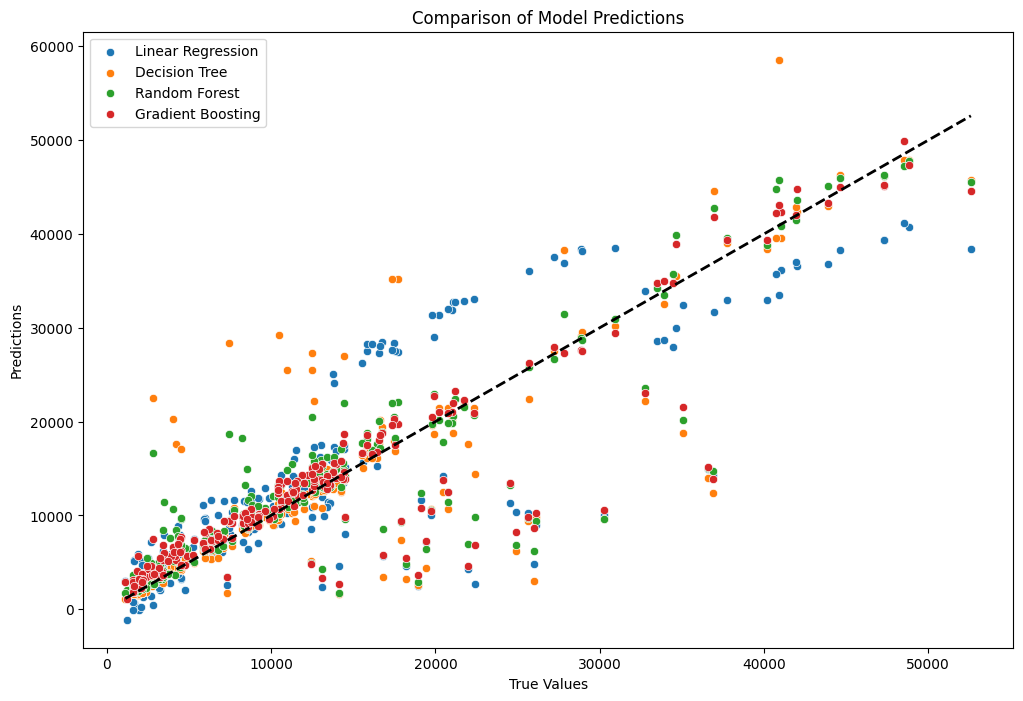

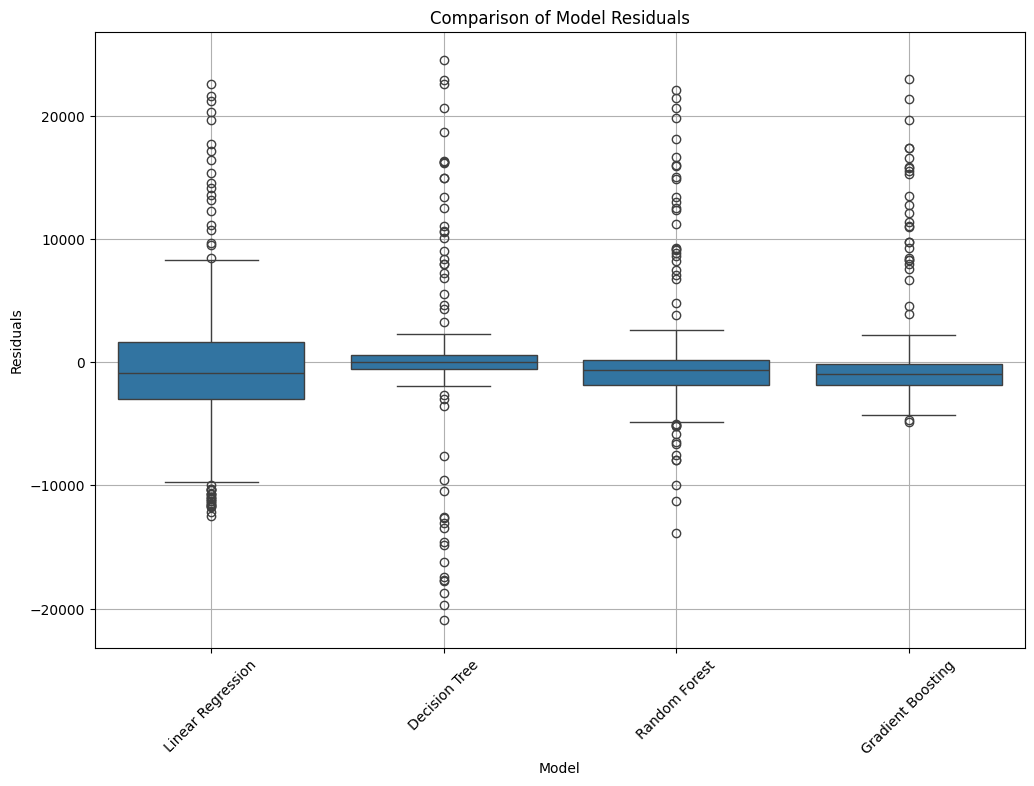

KeyError: "['charges'] not found in axis"

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

def clean_dataset(insurance):
    insurance['sex'] = insurance['sex'].replace({'M': 'male', 'man': 'male', 'F': 'female', 'woman': 'female'})
    if 'charges' in insurance.columns:
        insurance['charges'] = insurance['charges'].replace({'\$': ''}, regex=True).astype(float)
    insurance = insurance[insurance["age"] > 0]
    insurance.loc[insurance["children"] < 0, "children"] = 0
    insurance["region"] = insurance["region"].str.lower()
    
    return insurance.dropna()

insurance_data_path = 'insurance.csv'
insurance = pd.read_csv(insurance_data_path)
cleaned_insurance = clean_dataset(insurance)

X = cleaned_insurance.drop('charges', axis=1)
y = cleaned_insurance['charges']
X = pd.get_dummies(X, columns=['sex', 'smoker', 'region'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100)
}

results = {}
for name, model in models.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', model)])
    pipeline.fit(X_train, y_train)  # Fit model using the pipeline
    y_pred = pipeline.predict(X_test)  # Predict on test set
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = (mse, r2, y_pred)
    print(f"{name} - Test MSE: {mse:.2f}, Test R2: {r2:.2f}")
    
    if name == "Gradient Boosting":
        feature_importances = pipeline.named_steps['regressor'].feature_importances_
        features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=True)
        # Plotting feature importances
        plt.figure(figsize=(10, 6))
        features.plot(kind='barh', color='skyblue')
        plt.title('Feature Importances in Gradient Boosting Model')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()

# Plotting predictions for each model
plt.figure(figsize=(12, 8))
for name, (_, _, y_pred) in results.items():
    sns.scatterplot(x=y_test, y=y_pred, label=name)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line for perfect predictions
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Comparison of Model Predictions')
plt.legend()
plt.show()

# Calculate residuals for each model
residuals = {name: y_test - preds[2] for name, preds in results.items()}
residuals_df = pd.DataFrame(residuals)
residuals_df = residuals_df.melt(var_name='Model', value_name='Residuals')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Model', y='Residuals', data=residuals_df)
plt.title('Comparison of Model Residuals')
plt.ylabel('Residuals')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

validation_data = pd.read_csv('validation_dataset.csv')
validation_data_preprocessed = clean_dataset(validation_data)

X_validation = validation_data_preprocessed.drop('charges', axis=1)
y_validation = validation_data_preprocessed['charges']

gradient_boosting_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(n_estimators=100))
])
gradient_boosting_model.fit(X_train, y_train)
y_pred_validation = gradient_boosting_model.predict(X_validation)

# Evaluate the performance
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)

print(f"Validation MSE: {mse_validation:.2f}")
print(f"Validation R2: {r2_validation:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_validation, y_pred_validation, alpha=0.6)
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'k--', lw=2)  # Line for perfect predictions
plt.xlabel('True Charges')
plt.ylabel('Predicted Charges')
plt.title('Gradient Boosting Model Predictions on Validation Data')
plt.show()
